<a href="https://colab.research.google.com/github/YashK07/Stacking-Ensembling/blob/main/Ensemble_Stacking_in_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping
from keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout
from numpy import dstack
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
import numpy as np
import glob
import os
from sklearn import metrics

In [129]:
# load models from file
def load_all_models(n_models, modelList):
#     modelList = [ 'ResNet152-4', 'resnet50-4']
    all_models = list()
    for i in range(n_models):
        # define filename for this ensemble
        filename = modelList[i] + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

In [130]:
n_members = 4
modelList = ['ResNet152-4', 'VGG16-4', 'VGG19-4', 'resnet50-4']
members = load_all_models(n_members, modelList)
print('Loaded %d models' % len(members))

>loaded ResNet152-4.h5
>loaded VGG16-4.h5
>loaded VGG19-4.h5
>loaded resnet50-4.h5
Loaded 4 models


In [131]:
from keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

train_path = r'C:\Users\Ezazr\Desktop\UNet-TF-new\Classification-Dataset - Cross Validation 4 fold\Fold 4\train'
test_path = r'C:\Users\Ezazr\Desktop\UNet-TF-new\Classification-Dataset - Cross Validation 4 fold\Fold 4\test'
validation_path = r'C:\Users\Ezazr\Desktop\UNet-TF-new\Classification-Dataset - Cross Validation 4 fold\Fold 4\validation'
batch_size = 32

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = batch_size,
                                            class_mode = 'categorical',
                                            shuffle=False)
validation_set = validation_datagen.flow_from_directory(validation_path,
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

Found 107 images belonging to 2 classes.
Found 88 images belonging to 2 classes.
Found 714 images belonging to 2 classes.


In [132]:
stackedX_res = []
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
#     print('prediction')
    stackX = None
    for model in range(n_members):
        # make prediction
#         print('make prediction')
        yhat = members[model].predict(inputX)
#         print(yhat)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat #
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    stackedX_res = stackX
#     print(stackX,'\n',stackX.shape)
    return stackX

In [133]:

# fit a model based on the outputs from the ensemble members
# def fit_stacked_model(members, inputX, inputy):
#     # create dataset using ensemble
#     stackedX = stacked_dataset(members, inputX)
#     # fit standalone model
#     model = LogisticRegression() #meta learner
#     model.fit(stackedX, inputy)
#     return model
# def fit_stacked_model(members, inputX, inputy):
#     # create dataset using ensemble
    
#     stackedX = stacked_dataset(members, inputX)
#     print(stackedX,'\n',stackedX.shape)
#     # fit standalone model
# #     model = LogisticRegression() #meta learner
# #     model.fit(stackedX, inputy)
# #     return model
#     return None

In [134]:
# # model = fit_stacked_model(members, X_test, y_test)
# model = fit_stacked_model(members, train_set, validation_set)
# # members[1].predict(validation_set)

In [151]:
# stackX = None
# for model in range(n_members):
#     # make prediction
#     print('make prediction')
#     yhat = members[model].predict(test_set)
#     print(yhat)
#     # stack predictions into [rows, members, probabilities]
#     if stackX is None:
#         stackX = yhat #
#     else:
#         stackX = dstack((stackX, yhat))
# # flatten predictions to [rows, members x probabilities]
# stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))

stackX = stacked_dataset(members, test_set)

In [152]:
print(stackX.shape)

(107, 8)


In [153]:

# testDatalevel = []
# for i in range(107):
#     if(i < 37):
#         testDatalevel.append(1)
#     else:
#         testDatalevel.append(0)
# testDatalevel = np.array(testDatalevel)



Aedes_Count = 0;
testDatalevel = []
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob(test_path + "/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(label == 'Aedes'):
            Aedes_Count = Aedes_Count + 1;
            testDatalevel.append(0)
        else:
            testDatalevel.append(1)
        
testDatalevel = np.array(testDatalevel)


In [154]:

modelSVM = svm.SVC(decision_function_shape='ovo')
modelLR = LogisticRegression() #meta learner
modelKNN = KNeighborsClassifier(n_neighbors=3)
modelNB = GaussianNB()

modelSVM.fit(stackX, testDatalevel)
modelLR.fit(stackX, testDatalevel)
modelKNN.fit(stackX, testDatalevel)
modelNB.fit(stackX, testDatalevel)


GaussianNB()

In [160]:
# create dataset using ensemble
stackedX = stacked_dataset(members, test_set)
# make a prediction
# yhat = model.predict(stackedX)


In [156]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [157]:
def print_confusion_metrix_and_accuracy(yhat, model_name):
    print('\n',model_name)
    score = f1_m(testDatalevel/1.0, yhat/1.0)
    print('Stacked F Score:', score)
    accuracy = metrics.accuracy_score(testDatalevel, yhat)
    print('Accuracy Score:', score)


    confusion = metrics.confusion_matrix(testDatalevel, yhat)
    print(confusion)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    SPC = TN / float(TN+FP)
    TPR = TP / float(TP+FN)
    print('\nSPC = ', SPC, '\nTPR = ', TPR)
    

In [158]:
y_scoreKNN = modelKNN.predict(stackedX)
print_confusion_metrix_and_accuracy(y_scoreKNN, 'KNN')




 KNN
Stacked F Score: tf.Tensor(0.9928057039697763, shape=(), dtype=float64)
Accuracy Score: tf.Tensor(0.9928057039697763, shape=(), dtype=float64)
[[37  0]
 [ 1 69]]

SPC =  1.0 
TPR =  0.9857142857142858


In [161]:
y_scoreLR = modelLR.predict(stackedX)
print_confusion_metrix_and_accuracy(y_scoreLR, 'LR')

y_scoreSVM = modelSVM.predict(stackedX)
print_confusion_metrix_and_accuracy(y_scoreSVM, 'SVM')

y_scoreKNN = modelKNN.predict(stackedX)
print_confusion_metrix_and_accuracy(y_scoreKNN, 'KNN')

y_scoreNB = modelNB.predict(stackedX)
print_confusion_metrix_and_accuracy(y_scoreNB, 'NB')


 LR
Stacked F Score: tf.Tensor(0.999999948571431, shape=(), dtype=float64)
Accuracy Score: tf.Tensor(0.999999948571431, shape=(), dtype=float64)
[[37  0]
 [ 0 70]]

SPC =  1.0 
TPR =  1.0

 SVM
Stacked F Score: tf.Tensor(0.999999948571431, shape=(), dtype=float64)
Accuracy Score: tf.Tensor(0.999999948571431, shape=(), dtype=float64)
[[37  0]
 [ 0 70]]

SPC =  1.0 
TPR =  1.0

 KNN
Stacked F Score: tf.Tensor(0.999999948571431, shape=(), dtype=float64)
Accuracy Score: tf.Tensor(0.999999948571431, shape=(), dtype=float64)
[[37  0]
 [ 0 70]]

SPC =  1.0 
TPR =  1.0

 NB
Stacked F Score: tf.Tensor(0.9787233528695766, shape=(), dtype=float64)
Accuracy Score: tf.Tensor(0.9787233528695766, shape=(), dtype=float64)
[[35  2]
 [ 1 69]]

SPC =  0.9459459459459459 
TPR =  0.9857142857142858


In [170]:
y_scoreSVM


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [171]:
from sklearn.metrics import roc_curve, auc
import glob

Aedes_Count = 0;
test_labels = []
#for directory_path in glob.glob("cell_images/test/*"): 
for directory_path in glob.glob(test_path + "/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        if(label == 'Aedes'):
            Aedes_Count = Aedes_Count + 1;
            test_labels.append(0)
        else:
            test_labels.append(1)
        
test_labels = np.array(test_labels)

def get_datalevel2():
    datalevel= []
    for i in range(len(test_labels)):
        if(i < Aedes_Count):
            datalevel.append([1,0])
        else:
            datalevel.append([0,1])
    return np.array(datalevel)

In [172]:
def get_y_test(y_test):
    y_test_new = []
    for i in range(len(y_test)):
        if(y_test[i]==0):
            y_test_new.append([1,0])
        else:
            y_test_new.append([0,1])

    y_test_new = np.array(y_test_new) 
    return y_test_new


In [177]:
y_test_probality = get_datalevel2()
y_score_LR = get_y_test(y_scoreLR)
y_score_SVM = get_y_test(y_scoreSVM)
y_score_KNN = get_y_test(y_scoreKNN)
y_score_NB = get_y_test(y_scoreNB)

fpr = dict()
tpr = dict()
roc_auc = dict()
fpr1 = dict()
tpr1 = dict()
roc_auc1 = dict()
fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
fpr3 = dict()
tpr3 = dict()
roc_auc3 = dict()


for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test_probality[:, i], y_score_LR[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
for i in range(2):
    fpr1[i], tpr1[i], _ = roc_curve(y_test_probality[:, i], y_score_SVM[:, i])
    roc_auc1[i] = auc(fpr1[i], tpr1[i])
    
for i in range(2):
    fpr2[i], tpr2[i], _ = roc_curve(y_test_probality[:, i], y_score_KNN[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    
for i in range(2):
    fpr3[i], tpr3[i], _ = roc_curve(y_test_probality[:, i], y_score_NB[:, i])
    roc_auc3[i] = auc(fpr3[i], tpr3[i])
    
print('LR', roc_auc, ' SVM', roc_auc1, ' Knn', roc_auc2, ' NB', roc_auc3)

LR {0: 1.0, 1: 1.0}  SVM {0: 1.0, 1: 1.0}  Knn {0: 1.0, 1: 1.0}  NB {0: 0.965830115830116, 1: 0.9658301158301159}


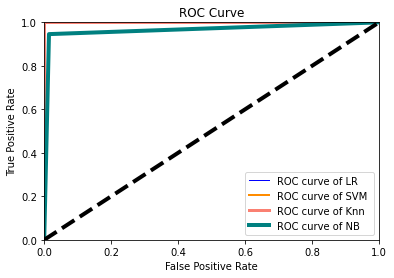

In [180]:
colors = ["blue", "darkorange", "salmon", 'teal']
classes = ['LR', 'SVM', 'Knn', 'NB']

plt.figure()
lw = 4

plt.plot(
    fpr[0],
    tpr[0],
    color=colors[0],
    lw=1,
    label="ROC curve of {0} ".format(classes[0]),
)
plt.plot(
    fpr1[0],
    tpr1[0],
    color=colors[1],
    lw=2,
    label="ROC curve of {0} ".format(classes[1]),
)
plt.plot(
    fpr2[0],
    tpr2[0],
    color=colors[2],
    lw=3,
    label="ROC curve of {0} ".format(classes[2]),
)
plt.plot(
    fpr3[0],
    tpr3[0],
    color=colors[3],
    lw=4,
    label="ROC curve of {0} ".format(classes[3]),
)

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

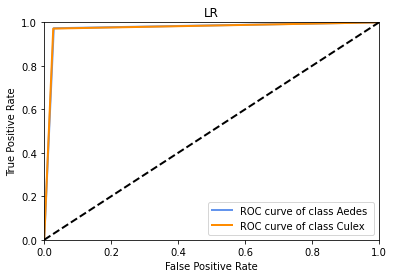

In [175]:
colors = ["cornflowerblue", "darkorange"]
classes = ['Aedes','Culex']

plt.figure()
lw = 2
for i in range(2):
    plt.plot(
        fpr[i],
        tpr[i],
        color=colors[i],
        lw=lw,
        label="ROC curve of class {0} ".format(classes[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LR")
plt.legend(loc="lower right")
plt.show()

In [144]:
# yhat = modelKNN.predict(stackedX)
# print(yhat)
# score = f1_m(testDatalevel/1.0, yhat/1.0)
# print('Stacked F Score:', score)
# accuracy = metrics.accuracy_score(testDatalevel, yhat)
# print('Accuracy Score:', score)


# confusion = metrics.confusion_matrix(testDatalevel, yhat)
# print(confusion)

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives
# SPC = TN / float(TN+FP)
# TPR = TP / float(TP+FN)
# print('\nSPC = ', SPC, '\nTPR = ', TPR)

In [145]:

# # make a prediction with the stacked model
# def stacked_prediction(members, model, inputX):
#     # create dataset using ensemble
#     stackedX = stacked_dataset(members, inputX)
#     # make a prediction
#     yhat = model.predict(stackedX)
#     return yhat

In [146]:

# # evaluate model on test set
# yhat = stacked_prediction(members, model, X_test)
# score = f1_m(y_test/1.0, yhat/1.0)
# print('Stacked F Score:', score)

In [147]:
from sklearn.metrics import f1_score

In [148]:
for j in range(n_members):
    y_score = members[j].predict(test_set)
    
    test_labels_predict = []
    
    for i in range(len(y_score)):
        if(y_score[i][0] > y_score[i][1]):
            test_labels_predict.append(0)
        else:
            test_labels_predict.append(1)
            
    accuracy = metrics.accuracy_score(testDatalevel, test_labels_predict)   
    score = f1_score(testDatalevel, test_labels_predict)
    print('Model {}  '.format(modelList[j]), 'F-Score : ', score, 'Accuracy : ', accuracy)

Model ResNet152-4   F-Score :  0.962962962962963 Accuracy :  0.9532710280373832
Model VGG16-4   F-Score :  0.9784172661870504 Accuracy :  0.9719626168224299
Model VGG19-4   F-Score :  0.9787234042553192 Accuracy :  0.9719626168224299
Model resnet50-4   F-Score :  0.9784172661870504 Accuracy :  0.9719626168224299
